Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('data/text8.zip', 31344016)

Found and verified data/text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000
_UNK = 'UNK'

def build_dataset(words):
    # count occurrences of common words
    count = [[_UNK, -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # assign index to most common words
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    # a list of indices representing each word at their respective position
    # replace uncommon words with index of UNK
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = dictionary[_UNK]
            unk_count += 1
        data.append(index)
    # contains each common word and its amount of occurences
    count[0][1] = unk_count
    # reverse dictionary for easy querying
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('Sample reverse dictionary', [reverse_dictionary[idx] for idx in data[:10]])
del words # reduce memory

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3083, 12, 6, 195, 2, 3136, 46, 59, 156]
Sample reverse dictionary ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'a', 'originated', 'as', 'of', 'term', 'originated']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

def run_graph(graph):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(
              batch_size, num_skips, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        return normalized_embeddings.eval()
final_embeddings = run_graph(graph)

Initialized
Average loss at step 0: 7.802903
Nearest to five: humanists, catalan, recursive, karami, inflectional, gigahertz, catatonic, dictation,
Nearest to into: urbanization, refitted, assistance, spectrometry, milligrams, smash, boyne, irt,
Nearest to there: paulus, albanian, rewrites, displays, audacity, confines, katal, rilke,
Nearest to most: ipc, herero, glossy, rainier, arpanet, purple, gelasian, bruton,
Nearest to also: nanette, annoy, feldspar, mcclure, uterus, electronegative, genteel, sergey,
Nearest to their: unintentionally, petro, conway, apostolic, verily, jungian, herons, meatballwiki,
Nearest to they: speedup, aichi, yockey, cris, silesian, pointer, tone, empowering,
Nearest to been: jacquard, flu, castile, dina, micronesian, boece, meteors, foreseen,
Nearest to all: flourish, pretending, coconuts, spectroscopic, height, urinating, eurostar, decimal,
Nearest to this: dhtml, hunchback, spassky, mclachlan, brew, dogg, uniform, bout,
Nearest to up: nuh, cinematic, perc

Average loss at step 54000: 3.423037
Average loss at step 56000: 3.439753
Average loss at step 58000: 3.393401
Average loss at step 60000: 3.394744
Nearest to five: six, four, three, eight, seven, zero, nine, two,
Nearest to into: through, from, over, in, towards, within, pounds, out,
Nearest to there: they, it, still, now, she, he, often, this,
Nearest to most: some, more, many, undisputed, less, all, selberg, veto,
Nearest to also: now, often, still, sometimes, never, actually, usually, there,
Nearest to their: its, his, her, the, our, my, your, some,
Nearest to they: there, we, you, he, she, actually, these, it,
Nearest to been: become, be, was, were, karaca, had, arisen, incorrectly,
Nearest to all: both, many, any, some, those, these, various, benchmarking,
Nearest to this: which, it, that, there, the, some, rada, suspicious,
Nearest to up: off, down, out, them, him, back, meade, sejanus,
Nearest to three: five, four, six, eight, seven, two, nine, zero,
Nearest to would: could, wi

In [8]:
num_points = 400

def tsne_embeddings(embeddings):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    # slice from first element, because of UNK
    two_d_embeddings = tsne.fit_transform(embeddings[1:num_points+1, :])
    return two_d_embeddings
two_d_embeddings = tsne_embeddings(final_embeddings)

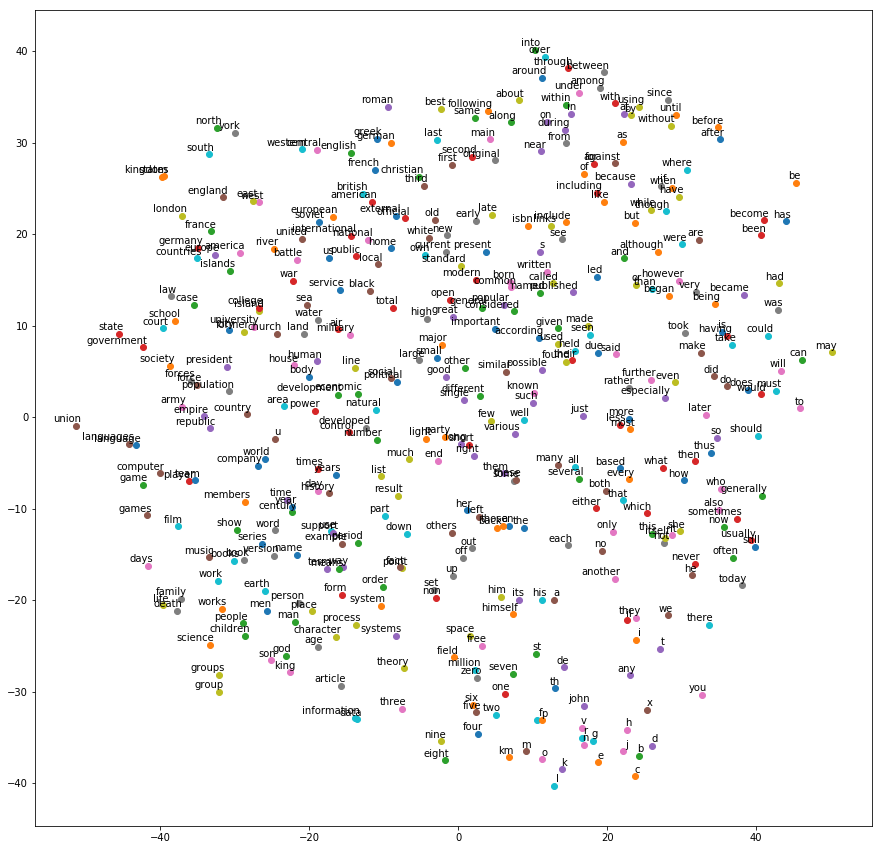

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

### CBOW batches

**NOTE** the shape of the labels.

- The `sampled_softmax_loss` takes an argument of labels where the second dimension says how many true targets the labels have.

Given a list of input words, the CBOW batches contain the surrounding words of a single target word.

In [10]:
data_index = 0

def generate_batch(batch_size, skip_window):
    global data_index
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(skip_window)
        batch[i] = buffer_list
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('\nwith skip_window = %d:' % (skip_window))
    print('    batch:', [[reverse_dictionary[b] for b in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

cbow_graph = tf.Graph()

with cbow_graph.as_default():
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, (skip_window * 2)])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Look up embeddings for inputs.
    # NOTE the sum of the input vectors
    embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset), 1)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001
def run_graph(graph):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(
              batch_size, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        return normalized_embeddings.eval()
final_embeddings = run_graph(cbow_graph)

Initialized
Average loss at step 0: 8.584380
Nearest to so: ventral, explorer, month, abstracts, outbursts, admits, bird, sram,
Nearest to has: peritoneum, astronautica, accent, shaka, shawn, spells, psychometrics, ricimer,
Nearest to in: nola, propelled, customary, weren, relator, sayer, mar, dalits,
Nearest to for: shoals, someday, invictus, directory, pavement, willamette, wearing, drafting,
Nearest to also: shades, leuven, diacritical, napkin, enrichment, wilkes, ugarit, alludes,
Nearest to a: krzysztof, covered, striking, commanding, rna, fatah, kauffman, plaintiff,
Nearest to into: infancy, soundtracks, workforce, castilian, press, instrumental, vf, gleichschaltung,
Nearest to on: jumbo, merge, mislead, peruvian, triumph, barefoot, beast, corse,
Nearest to by: commanded, oligocene, blockage, exorcism, thermotropic, evolutionary, streaming, sonia,
Nearest to years: haller, luncheon, fln, call, bcg, celebrated, yom, boxing,
Nearest to six: shiite, gzip, harrier, applets, fluorescen

Average loss at step 52000: 3.005593
Average loss at step 54000: 2.969489
Average loss at step 56000: 3.050301
Average loss at step 58000: 3.062205
Average loss at step 60000: 2.876079
Nearest to so: sorcerers, quarantine, inspectors, sometimes, too, simone, redirected, suppose,
Nearest to has: had, have, having, contains, includes, is, provides, congratulated,
Nearest to in: throughout, within, on, during, since, through, hasbro, ol,
Nearest to for: vestments, suppressive, tiling, after, following, ayyash, sadat, brodie,
Nearest to also: below, now, disambiguation, flap, currently, palmyra, yarmouth, often,
Nearest to a: another, the, every, any, this, alanine, potable, tossing,
Nearest to into: through, across, within, onto, between, around, salle, entheogen,
Nearest to on: upon, in, through, limericks, onto, golding, wesley, iadb,
Nearest to by: ailment, reassessment, without, tanistry, drysdale, nameserver, avicenna, insular,
Nearest to years: days, months, decades, hours, weeks, y

Illustrate how an embedding is just a vector

In [15]:
final_embeddings[0]

array([ 0.00652755, -0.13374557, -0.04962846, -0.17904007, -0.13590232,
       -0.04003021, -0.09159455,  0.13089722, -0.00348005, -0.05247471,
        0.03966789, -0.06941137, -0.00073502, -0.0221133 , -0.00994064,
       -0.05100011,  0.06363631,  0.01280606, -0.01695368, -0.11843554,
       -0.00419066,  0.02757116, -0.04555554, -0.05046418,  0.02870836,
        0.02889772, -0.03172832,  0.0019729 , -0.07064503,  0.07064646,
        0.01334452,  0.04756901,  0.01754802,  0.05566818,  0.05492533,
       -0.0012713 , -0.0852989 , -0.07722863,  0.09938953,  0.19421898,
        0.11277575, -0.02008118, -0.09664029,  0.0505993 ,  0.01090028,
       -0.01206634, -0.25684348,  0.03205332,  0.14183816,  0.09962456,
       -0.0214575 , -0.01908396, -0.00672291,  0.0723701 ,  0.04561874,
       -0.02358717,  0.04003387,  0.05422562,  0.1497028 ,  0.19290352,
        0.06400565, -0.04073425, -0.05493394,  0.1109672 , -0.03842654,
        0.01126538, -0.01824301,  0.08449195,  0.0237339 ,  0.10

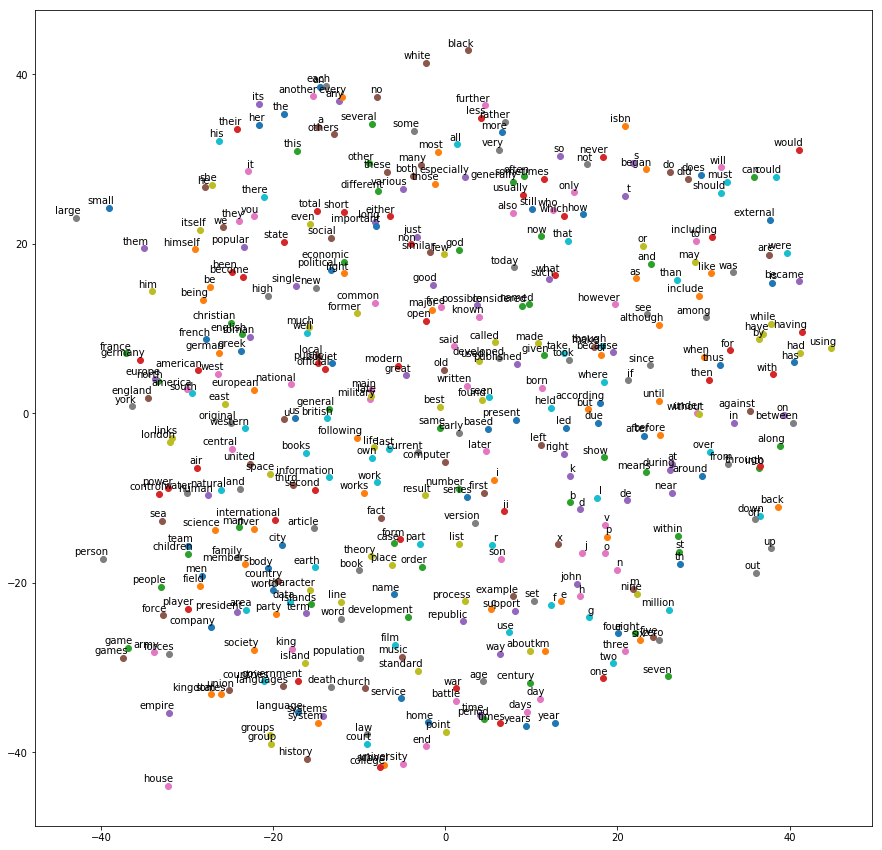

In [16]:
two_d_embeddings = tsne_embeddings(final_embeddings)
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Thoughts

The `embed` variable in the graph performs a lookup in the hidden layer's weights.
These weights are also called embeddings.
Imagine that each row in the weights is a single embedding that represents a word.

The CBOW model may perform a bit better if there is a lot of data, 
where the skip-gram model can get decent results even from smaller amounts of data.

This is due to the fact that the skip-gram model tries to predict multiple likely targets for every input.